In [46]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset

In [47]:
## Step 1: Load and Preprocess Data
# Load training and test datasets
df_train = pd.read_csv('trainset.csv')
df_test = pd.read_csv('testset.csv')

In [48]:
df_train.head()
df_test.head()

,Date,Open,High,Low,Close,Adj Close,Volume
0,2018-01-02,1048.339966,1066.939941,1045.229980,1065.000000,1065.000000,1237600
1,2018-01-03,1064.310059,1086.290039,1063.209961,1082.479980,1082.479980,1430200
2,2018-01-04,1088.000000,1093.569946,1084.001953,1086.400024,1086.400024,1004600
3,2018-01-05,1094.000000,1104.250000,1092.000000,1102.229980,1102.229980,1279100
4,2018-01-08,1102.229980,1111.270020,1101.619995,1106.939941,1106.939941,1047600


In [49]:
# Use closing prices
train_prices = df_train['Close'].values.reshape(-1, 1)
test_prices = df_test['Close'].values.reshape(-1, 1)

In [50]:
# Normalize the data based on training set only
scaler = MinMaxScaler()
scaled_train = scaler.fit_transform(train_prices)
scaled_test = scaler.transform(test_prices)

In [51]:
# Create sequences
def create_sequences(data, seq_length):
    x = []
    y = []
    for i in range(len(data) - seq_length):
        x.append(data[i:i+seq_length])
        y.append(data[i+seq_length])
    return np.array(x), np.array(y)

seq_length = 60
x_train, y_train = create_sequences(scaled_train, seq_length)
x_test, y_test = create_sequences(scaled_test, seq_length)


In [52]:
x_train.shape, y_train.shape, x_test.shape, y_test.shape

((1199, 60, 1), (1199, 1), (65, 60, 1), (65, 1))

In [53]:
# Convert to PyTorch tensors
x_train_tensor = torch.tensor(x_train, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train, dtype=torch.float32)
x_test_tensor = torch.tensor(x_test, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test, dtype=torch.float32)


In [54]:
# Create dataset and dataloader
train_dataset = TensorDataset(x_train_tensor, y_train_tensor)
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)

In [55]:
## Step 2: Define RNN Model
class RNNModel(nn.Module):
    def __init__(self, input_size=1, hidden_size=64, num_layers=2, output_size=1):
        super(RNNModel, self).__init__()

        self.rnn = nn.RNN(input_size, hidden_size, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        out, _ = self.rnn(x)
        out = self.fc(out[:, -1, :])
        return out


In [56]:
model = RNNModel()
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)

In [57]:
!pip install torchinfo

In [58]:
from torchinfo import summary
# input_size = (batch_size, seq_len, input_size)
summary(model, input_size=(64, 60, 1))

Layer (type:depth-idx)                   Output Shape              Param #
RNNModel                                 [64, 1]                   --
├─RNN: 1-1                               [64, 60, 64]              12,608
├─Linear: 1-2                            [64, 1]                   65
Total params: 12,673
Trainable params: 12,673
Non-trainable params: 0
Total mult-adds (Units.MEGABYTES): 48.42
Input size (MB): 0.02
Forward/backward pass size (MB): 1.97
Params size (MB): 0.05
Estimated Total Size (MB): 2.03

In [59]:
criterion =  nn.MSELoss()
optimizer =  torch.optim.Adam(model.parameters(),lr=0.001)

In [60]:
## Step 3: Train the Model

def train_model(model, train_loader, criterion, optimizer, num_epochs=20):
  train_losses = []
  model.train()

  for epoch in range(num_epochs):
    total_loss = 0
    for x_batch,y_batch in train_loader:
      x_batch, y_batch = x_batch.to(device), y_batch.to(device)
      optimizer.zero_grad()
      outputs = model(x_batch)
      loss = criterion(outputs, y_batch)
      loss.backward()
      optimizer.step()
      total_loss += loss.item()
    train_losses.append(total_loss/ len(train_loader))
    print(f'Epoch [{epoch+1}/{num_epochs}], loss: {total_loss / len(train_loader):.4f}')
  return train_losses

Name: Mohammad Suhael
Register Number: 212224230164
Epoch [1/20], loss: 0.0491
Epoch [2/20], loss: 0.0032
Epoch [3/20], loss: 0.0009
Epoch [4/20], loss: 0.0005
Epoch [5/20], loss: 0.0004
Epoch [6/20], loss: 0.0004
Epoch [7/20], loss: 0.0004
Epoch [8/20], loss: 0.0003
Epoch [9/20], loss: 0.0003
Epoch [10/20], loss: 0.0003
Epoch [11/20], loss: 0.0004
Epoch [12/20], loss: 0.0004
Epoch [13/20], loss: 0.0003
Epoch [14/20], loss: 0.0003
Epoch [15/20], loss: 0.0003
Epoch [16/20], loss: 0.0003
Epoch [17/20], loss: 0.0003
Epoch [18/20], loss: 0.0003
Epoch [19/20], loss: 0.0003
Epoch [20/20], loss: 0.0003


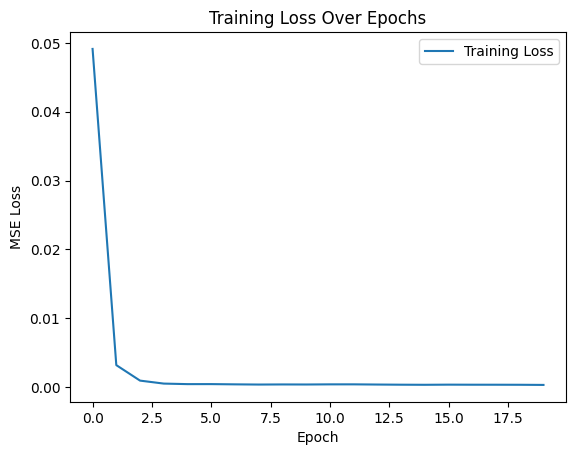

In [61]:
# Plot training loss
print('Name: Mohammad Suhael')
print('Register Number: 212224230164')

train_losses = train_model(model, train_loader, criterion, optimizer, num_epochs=20)

plt.plot(train_losses, label='Training Loss')
plt.xlabel('Epoch')
plt.ylabel('MSE Loss')
plt.title('Training Loss Over Epochs')
plt.legend()
plt.show()

Name: Mohammad SUhael
Register Number: 212224230164


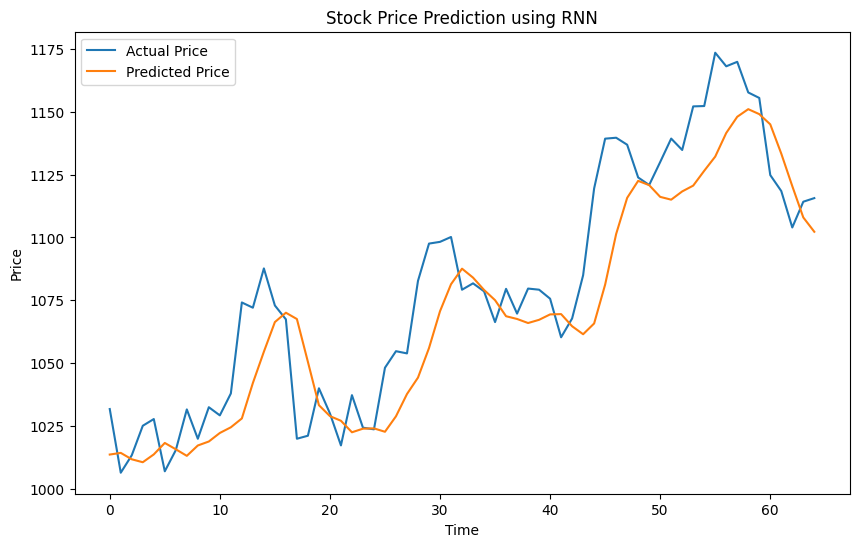

Predicted Price: [1102.2717]
Actual Price: [1115.65]


In [63]:
## Step 4: Make Predictions on Test Set
model.eval()
with torch.no_grad():
    predicted = model(x_test_tensor.to(device)).cpu().numpy()
    actual = y_test_tensor.cpu().numpy()

# Inverse transform the predictions and actual values
predicted_prices = scaler.inverse_transform(predicted)
actual_prices = scaler.inverse_transform(actual)

# Plot the predictions vs actual prices
print('Name: Mohammad SUhael')
print('Register Number: 212224230164')
plt.figure(figsize=(10, 6))
plt.plot(actual_prices, label='Actual Price')
plt.plot(predicted_prices, label='Predicted Price')
plt.xlabel('Time')
plt.ylabel('Price')
plt.title('Stock Price Prediction using RNN')
plt.legend()
plt.show()
print(f'Predicted Price: {predicted_prices[-1]}')
print(f'Actual Price: {actual_prices[-1]}')